BASELINE MODEL WITH SVM

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [7]:

df = pd.read_pickle("../../../data/processed/balanced_df.pkl")

X = df['text'].astype(str)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=42,
    stratify=df['label']   
)

print(f"Train Size: {len(X_train)}, Test Size: {len(X_test)}")

Train Size: 136184, Test Size: 34046


In [8]:
# pipeline = Pipeline([
#     ('tfidf',TfidfVectorizer()),
#     ('clf',LinearSVC())
# ])

In [9]:
# param_grid = {
#     'tfidf__ngram_range': [(1,1),(1,2)],
#     'tfidf__min_df': [1,3],
#     'tfidf__max_df':[0.9],
#     'tfidf__sublinear_tf':[True],
#     'tfidf__max_features': [5000],
#     'clf__C': [0.1,  1],
#     'clf__class_weight': [None, 'balanced']
# }

In [10]:
# grid = GridSearchCV(
#     pipeline,
#     param_grid,
#     cv=3,
#     scoring='f1_macro',
#     verbose=3,
#     n_jobs=1
# )

# grid.fit(X_train,y_train)

In [11]:
# Drop NaNs in train/test
X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]


In [12]:
# # Only if you want to remove literal "nan" strings too
# mask = X_train != 'nan'
# X_train = X_train[mask]
# y_train = y_train[mask]

In [13]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    max_df=0.9,
    min_df=5,
    ngram_range=(1,2),
    sublinear_tf=True
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print(f'Train TF-IDF shape: {X_train_vec.shape}')

Train TF-IDF shape: (136184, 5000)


In [14]:
svm_clf = LinearSVC(
    C = 1,
    class_weight='balanced',
    max_iter=5000
)

svm_clf.fit(X_train_vec,y_train)

LinearSVC(C=1, class_weight='balanced', max_iter=5000)

              precision    recall  f1-score   support

        FAKE     0.9987    0.2777    0.4346     17023
        REAL     0.5805    0.9996    0.7345     17023

    accuracy                         0.6387     34046
   macro avg     0.7896    0.6387    0.5846     34046
weighted avg     0.7896    0.6387    0.5846     34046



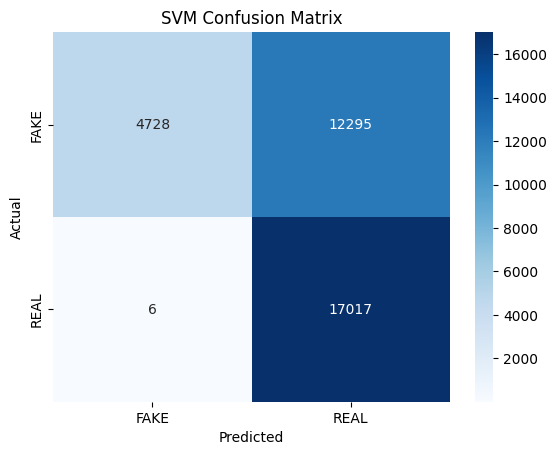

In [15]:
y_pred = svm_clf.predict(X_test_vec)

print(classification_report(y_test,y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',
            xticklabels=svm_clf.classes_,yticklabels=svm_clf.classes_)
plt.title("SVM Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## ROC CURVE AND THINGS

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # "REAL" -> 1, "FAKE" -> 0
y_test_enc  = le.transform(y_test)


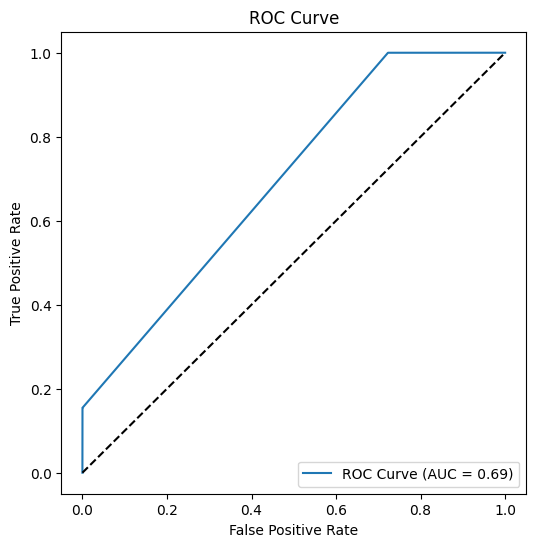

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Use decision_function (for SVM) or predict_proba (for LR, NB, etc.)
y_prob = svm_clf.decision_function(X_test_vec)

fpr, tpr, _ = roc_curve(y_test_enc, y_prob)
roc_auc = roc_auc_score(y_test_enc, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


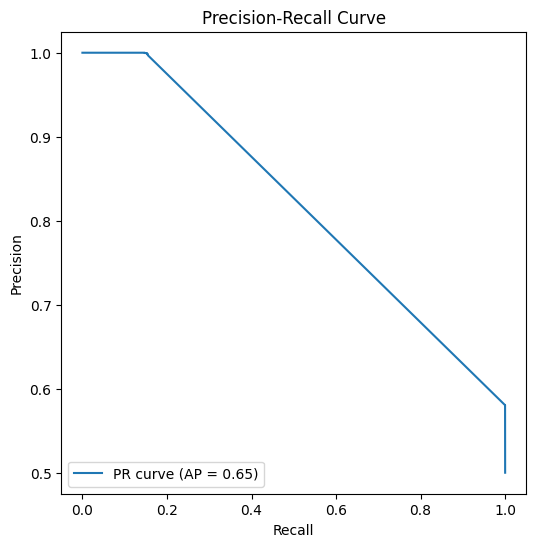

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test_enc, y_prob)
ap_score = average_precision_score(y_test_enc, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"PR curve (AP = {ap_score:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


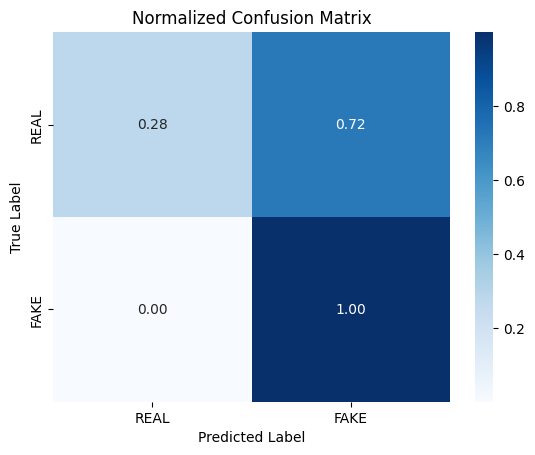

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, normalize="true")  # normalized
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=["REAL","FAKE"], yticklabels=["REAL","FAKE"])
plt.title("Normalized Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [27]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc = cross_val_score(svm_clf, X_train_vec, y_train, cv=cv, scoring="accuracy")
f1 = cross_val_score(svm_clf, X_train_vec, y_train, cv=cv, scoring="f1")
roc = cross_val_score(svm_clf, X_train_vec, y_train, cv=cv, scoring="roc_auc")

print("Cross-validation results:")
print(f"Accuracy: {acc.mean():.3f} ± {acc.std():.3f}")
print(f"F1 Score: {f1.mean():.3f} ± {f1.std():.3f}")
print(f"ROC-AUC:  {roc.mean():.3f} ± {roc.std():.3f}")


c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kknah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_response.py", line 207, in _get_response_values
  

Cross-validation results:
Accuracy: 0.637 ± 0.003
F1 Score: nan ± nan
ROC-AUC:  0.693 ± 0.002
